In [1]:
# import useful library and tools
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import json
from pycirclize import Circos

from connectiviz.calculating_connectivity import generate_edges_and_weights, generate_edges_and_weights_with_network, threshold_dataframe, count_network_pairs_above_threshold
from connectiviz.utils import rename_columns_by_region

/Users/jpillai/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jpillai/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [19]:
#Load in data (input: rois_roi_cor_coef.csv that outputs from the step 3 of IC Pipeline)
data_dir = '/Users/jpillai/Library/CloudStorage/Box-Box/Malu_Hulya_rtFTD-Project/jupyter-notebooks/Controls_FINAL_fMRI/harmonized_data'
rois_roi_cor_coef = pd.read_csv(f'{data_dir}/26278_HARMONIZED_rois_roi_cor_coef.csv', header=None)

In [20]:
# USE FUNCTION!!!!!

# Load in the subregions_Yeo7networks.csv file from the /data in this repository
df_networks = pd.read_csv('./data/subregions_Yeo7networks.csv')
with open('./data/Yeo_7network_names.json') as f:
    network_names = json.load(f)

# change the keys of network_names to integers
network_names = {int(k): v for k, v in network_names.items()}

In [21]:
network_mapping = df_networks.set_index('Label')['Yeo_7network'].to_dict()

In [22]:
# Rename the columns to the region names
rois_roi_cor_coef_df = rename_columns_by_region(rois_roi_cor_coef, df_networks)
rois_roi_cor_coef_df

# # Add region column from df_networks to p_values_df
rois_roi_cor_coef_df['region'] = df_networks['region']

# # Ensure 'region' and 'Yeo_17network' columns are at the beginning of t_stats_df
rois_roi_cor_coef_df['Yeo_7network'] = df_networks['Yeo_7network']
cols = ['region', 'Yeo_7network']  # these are the columns you want to move to the front
cols.extend([col for col in rois_roi_cor_coef_df.columns if col not in cols])

# # Reindex the DataFrame with the new column order
rois_roi_cor_coef_df = rois_roi_cor_coef_df[cols]

In [23]:
rois_roi_cor_coef_df

,region,Yeo_7network,SFG_L_7_1,SFG_R_7_1,SFG_L_7_2,SFG_R_7_2,SFG_L_7_3,SFG_R_7_3,SFG_L_7_4,SFG_R_7_4,...,Tha_L_8_4,Tha_R_8_4,Tha_L_8_5,Tha_R_8_5,Tha_L_8_6,Tha_R_8_6,Tha_L_8_7,Tha_R_8_7,Tha_L_8_8,Tha_R_8_8
0,SFG_L_7_1,6,1.000000,0.752261,0.267928,0.234015,0.231993,0.185073,0.657539,0.580111,...,0.226943,0.247075,0.264794,0.269992,0.219746,0.183376,0.178541,0.346992,0.346399,0.424032
1,SFG_R_7_1,4,0.752261,1.000000,0.487045,0.463584,0.501262,0.476522,0.669958,0.559565,...,0.437841,0.395019,0.334859,0.381798,0.361585,0.272769,0.299424,0.505437,0.423753,0.502379
2,SFG_L_7_2,7,0.267928,0.487045,1.000000,0.625159,0.754652,0.742677,0.251120,-0.019553,...,0.417110,0.306180,0.127785,0.102874,0.288242,0.060604,0.302833,0.319231,0.110378,0.202202
3,SFG_R_7_2,6,0.234015,0.463584,0.625159,1.000000,0.621458,0.674823,0.213502,0.225972,...,0.399798,0.340793,0.174012,0.355940,0.405288,0.368013,0.433594,0.428512,0.106816,0.186776
4,SFG_L_7_3,7,0.231993,0.501262,0.754652,0.621458,1.000000,0.858175,0.202887,0.127324,...,0.499260,0.422451,0.254584,0.187552,0.386245,0.140137,0.384295,0.384719,0.325828,0.219395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Tha_R_8_6,0,0.183376,0.272769,0.060604,0.368013,0.140137,0.158005,0.191200,0.264082,...,0.470058,0.463980,0.393822,0.642091,0.449378,1.000000,0.545377,0.544994,0.200495,0.405379
240,Tha_L_8_7,0,0.178541,0.299424,0.302833,0.433594,0.384295,0.311852,0.201325,0.272064,...,0.621299,0.509592,0.609271,0.493886,0.656079,0.545377,1.000000,0.652779,0.306749,0.464171
241,Tha_R_8_7,0,0.346992,0.505437,0.319231,0.428512,0.384719,0.339683,0.291421,0.388983,...,0.656898,0.556745,0.544745,0.628396,0.525052,0.544994,0.652779,1.000000,0.488443,0.632210
242,Tha_L_8_8,0,0.346399,0.423753,0.110378,0.106816,0.325828,0.243818,0.348830,0.434335,...,0.416442,0.385913,0.647658,0.482247,0.460054,0.200495,0.306749,0.488443,1.000000,0.651402


In [24]:
# order the columns by increasing network number
rois_roi_cor_coef_df = rois_roi_cor_coef_df.sort_values(by='Yeo_7network')
rois_roi_cor_coef_df

,region,Yeo_7network,SFG_L_7_1,SFG_R_7_1,SFG_L_7_2,SFG_R_7_2,SFG_L_7_3,SFG_R_7_3,SFG_L_7_4,SFG_R_7_4,...,Tha_L_8_4,Tha_R_8_4,Tha_L_8_5,Tha_R_8_5,Tha_L_8_6,Tha_R_8_6,Tha_L_8_7,Tha_R_8_7,Tha_L_8_8,Tha_R_8_8
243,Tha_R_8_8,0,0.424032,0.502379,0.202202,0.186776,0.219395,0.164633,0.434763,0.404078,...,0.530532,0.542848,0.720329,0.702051,0.619763,0.405379,0.464171,0.632210,0.651402,1.000000
226,BG_L_6_5,0,0.325175,0.428781,0.458329,0.294757,0.437287,0.426483,0.383320,0.327554,...,0.599972,0.407752,0.316335,0.247156,0.402822,0.149191,0.335715,0.465307,0.334983,0.359417
225,BG_R_6_4,0,0.034961,0.193932,0.099722,-0.142566,0.110079,0.102669,0.175609,0.146043,...,0.375197,0.296044,0.343879,0.224519,0.269443,0.003267,0.175353,0.393731,0.371091,0.408788
224,BG_L_6_4,0,0.021823,0.143923,0.062986,-0.148353,0.037733,0.032511,0.202605,0.162290,...,0.387264,0.328297,0.272878,0.208922,0.186715,0.091631,0.150804,0.269196,0.335913,0.305383
223,BG_R_6_3,0,0.260474,0.265230,0.288753,0.118569,0.317739,0.354794,0.335605,0.226105,...,0.494468,0.503252,0.247294,0.093978,0.312279,0.135041,0.200949,0.283917,0.147808,0.265556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,CG_L_7_4,7,-0.009372,0.141177,0.297558,0.509668,0.435482,0.367301,-0.033277,0.043166,...,0.483397,0.415548,0.301874,0.388913,0.564818,0.394715,0.457619,0.313135,0.124575,0.284620
42,OrG_L_6_2,7,0.177488,0.393142,0.609939,0.364942,0.669246,0.605925,0.211522,0.120942,...,0.548284,0.428814,0.195970,0.153704,0.378106,0.119335,0.357664,0.409755,0.249092,0.230659
41,OrG_R_6_1,7,-0.037204,0.243333,0.446459,0.579792,0.644880,0.642861,-0.001718,0.036167,...,0.595532,0.538232,0.254741,0.292964,0.522717,0.302314,0.418950,0.349652,0.178185,0.245259
86,MTG_L_4_4,7,0.006299,0.368579,0.642696,0.482192,0.642921,0.708202,0.096935,-0.079956,...,0.462841,0.290821,0.225292,0.187221,0.369656,0.012313,0.262326,0.317119,0.151428,0.241784


In [25]:
# replace the network numbers with the network names in a new column
rois_roi_cor_coef_df['network_name'] = rois_roi_cor_coef_df['Yeo_7network'].replace(network_names)
rois_roi_cor_coef_df['region_number'] = rois_roi_cor_coef_df.groupby('Yeo_7network').cumcount()
rois_roi_cor_coef_df

,region,Yeo_7network,SFG_L_7_1,SFG_R_7_1,SFG_L_7_2,SFG_R_7_2,SFG_L_7_3,SFG_R_7_3,SFG_L_7_4,SFG_R_7_4,...,Tha_L_8_5,Tha_R_8_5,Tha_L_8_6,Tha_R_8_6,Tha_L_8_7,Tha_R_8_7,Tha_L_8_8,Tha_R_8_8,network_name,region_number
243,Tha_R_8_8,0,0.424032,0.502379,0.202202,0.186776,0.219395,0.164633,0.434763,0.404078,...,0.720329,0.702051,0.619763,0.405379,0.464171,0.632210,0.651402,1.000000,Unassigned,0
226,BG_L_6_5,0,0.325175,0.428781,0.458329,0.294757,0.437287,0.426483,0.383320,0.327554,...,0.316335,0.247156,0.402822,0.149191,0.335715,0.465307,0.334983,0.359417,Unassigned,1
225,BG_R_6_4,0,0.034961,0.193932,0.099722,-0.142566,0.110079,0.102669,0.175609,0.146043,...,0.343879,0.224519,0.269443,0.003267,0.175353,0.393731,0.371091,0.408788,Unassigned,2
224,BG_L_6_4,0,0.021823,0.143923,0.062986,-0.148353,0.037733,0.032511,0.202605,0.162290,...,0.272878,0.208922,0.186715,0.091631,0.150804,0.269196,0.335913,0.305383,Unassigned,3
223,BG_R_6_3,0,0.260474,0.265230,0.288753,0.118569,0.317739,0.354794,0.335605,0.226105,...,0.247294,0.093978,0.312279,0.135041,0.200949,0.283917,0.147808,0.265556,Unassigned,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,CG_L_7_4,7,-0.009372,0.141177,0.297558,0.509668,0.435482,0.367301,-0.033277,0.043166,...,0.301874,0.388913,0.564818,0.394715,0.457619,0.313135,0.124575,0.284620,Default,31
42,OrG_L_6_2,7,0.177488,0.393142,0.609939,0.364942,0.669246,0.605925,0.211522,0.120942,...,0.195970,0.153704,0.378106,0.119335,0.357664,0.409755,0.249092,0.230659,Default,32
41,OrG_R_6_1,7,-0.037204,0.243333,0.446459,0.579792,0.644880,0.642861,-0.001718,0.036167,...,0.254741,0.292964,0.522717,0.302314,0.418950,0.349652,0.178185,0.245259,Default,33
86,MTG_L_4_4,7,0.006299,0.368579,0.642696,0.482192,0.642921,0.708202,0.096935,-0.079956,...,0.225292,0.187221,0.369656,0.012313,0.262326,0.317119,0.151428,0.241784,Default,34


In [26]:
#Based on a selected threshold, keep the values above or equal to the threshold
threshold = 0.4
thresholded_rois_roi_cor_coef_df = threshold_dataframe(rois_roi_cor_coef_df, threshold)
thresholded_rois_roi_cor_coef_df

,region,Yeo_7network,SFG_L_7_1,SFG_R_7_1,SFG_L_7_2,SFG_R_7_2,SFG_L_7_3,SFG_R_7_3,SFG_L_7_4,SFG_R_7_4,...,Tha_L_8_5,Tha_R_8_5,Tha_L_8_6,Tha_R_8_6,Tha_L_8_7,Tha_R_8_7,Tha_L_8_8,Tha_R_8_8,network_name,region_number
243,Tha_R_8_8,0,0.424032,0.502379,0.000000,0.000000,0.000000,0.000000,0.434763,0.404078,...,0.720329,0.702051,0.619763,0.405379,0.464171,0.632210,0.651402,1.000000,Unassigned,0
226,BG_L_6_5,0,0.000000,0.428781,0.458329,0.000000,0.437287,0.426483,0.000000,0.000000,...,0.000000,0.000000,0.402822,0.000000,0.000000,0.465307,0.000000,0.000000,Unassigned,1
225,BG_R_6_4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.408788,Unassigned,2
224,BG_L_6_4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Unassigned,3
223,BG_R_6_3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Unassigned,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,CG_L_7_4,7,0.000000,0.000000,0.000000,0.509668,0.435482,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.564818,0.000000,0.457619,0.000000,0.000000,0.000000,Default,31
42,OrG_L_6_2,7,0.000000,0.000000,0.609939,0.000000,0.669246,0.605925,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.409755,0.000000,0.000000,Default,32
41,OrG_R_6_1,7,0.000000,0.000000,0.446459,0.579792,0.644880,0.642861,0.000000,0.000000,...,0.000000,0.000000,0.522717,0.000000,0.418950,0.000000,0.000000,0.000000,Default,33
86,MTG_L_4_4,7,0.000000,0.000000,0.642696,0.482192,0.642921,0.708202,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Default,34


In [27]:
# Count the number of regions for each network and display in order
counts = thresholded_rois_roi_cor_coef_df['Yeo_7network'].value_counts().sort_index()

# INPUT 1 to CHORD PLOT: Replace the index of integers with the network names from network_names
counts.index = [network_names[i] for i in counts.index]

In [28]:
# INPUT 2 to CHORD PLOT: Dictionary of the network and the list of regions in that network
networks = {}
for network in counts.index:
    networks[network] = thresholded_rois_roi_cor_coef_df[thresholded_rois_roi_cor_coef_df['network_name'] == network]['region'].values
networks

{'Unassigned': array(['Tha_R_8_8', 'BG_L_6_5', 'BG_R_6_4', 'BG_L_6_4', 'BG_R_6_3',
        'BG_L_6_3', 'BG_R_6_2', 'BG_L_6_2', 'BG_R_6_1', 'Hipp_R_2_2',
        'Hipp_L_2_2', 'Hipp_R_2_1', 'Hipp_L_2_1', 'Amyg_R_2_2',
        'Amyg_L_2_2', 'Tha_L_8_8', 'Amyg_R_2_1', 'Amyg_L_2_1', 'BG_R_6_5',
        'BG_L_6_6', 'BG_L_6_1', 'Tha_L_8_1', 'CG_R_7_2', 'Tha_R_8_7',
        'Tha_L_8_7', 'BG_R_6_6', 'Tha_L_8_6', 'CG_L_7_2', 'INS_L_6_2',
        'Tha_R_8_5', 'Tha_L_8_5', 'Tha_R_8_6', 'Tha_L_8_4', 'Tha_R_8_1',
        'Tha_R_8_4', 'Tha_R_8_3', 'Tha_L_8_3'], dtype=object),
 'Visual': array(['MVOcC_L_5_4', 'LOcC_R_2_1', 'LOcC_L_2_1', 'LOcC_R_4_4',
        'LOcC_L_4_4', 'LOcC_R_4_3', 'LOcC_L_4_3', 'LOcC_R_4_2',
        'LOcC_R_4_1', 'FuG_L_3_2', 'FuG_R_3_2', 'FuG_R_3_3', 'PhG_R_6_2',
        'PhG_L_6_3', 'PhG_R_6_3', 'MVOcC_R_5_3', 'PhG_L_6_6',
        'MVOcC_L_5_3', 'LOcC_L_2_2', 'LOcC_L_4_1', 'PCun_R_4_3',
        'IPL_L_6_1', 'IPL_R_6_1', 'PCun_L_4_3', 'MVOcC_R_5_5',
        'MVOcC_R_5_2', 'MVOc

In [29]:
# # Generate edges and weights for the thresholded DataFrame
edges_weights = generate_edges_and_weights_with_network(thresholded_rois_roi_cor_coef_df, ['region', 'Yeo_7network', 'network_name', 'region_number'], 'Yeo_7network')
edges_weights

{(6, 6): 0.9999999999999966,
 (6, 4): 0.5545528907769368,
 (6, 7): 0.7002944518009467,
 (6, 3): 0.0,
 (6, 2): 0.0,
 (6, 5): 0.0,
 (6, 1): 0.0,
 (6, 0): 0.0,
 (4, 6): 0.5545528907769368,
 (4, 4): 0.9999999999999966,
 (4, 7): 0.6272085189373964,
 (4, 3): 0.0,
 (4, 2): 0.4493554916206131,
 (4, 5): 0.0,
 (4, 1): 0.0,
 (4, 0): 0.4060952826701337,
 (7, 6): 0.7002944518009467,
 (7, 4): 0.6272085189373964,
 (7, 7): 0.9999999999999966,
 (7, 3): 0.0,
 (7, 2): 0.0,
 (7, 5): 0.0,
 (7, 1): 0.0,
 (7, 0): 0.0,
 (3, 6): 0.0,
 (3, 4): 0.0,
 (3, 7): 0.0,
 (3, 3): 0.9999999999999966,
 (3, 2): 0.0,
 (3, 5): 0.0,
 (3, 1): 0.7471746719675937,
 (3, 0): 0.0,
 (2, 6): 0.0,
 (2, 4): 0.4493554916206131,
 (2, 7): 0.0,
 (2, 3): 0.0,
 (2, 2): 0.9999999999999966,
 (2, 5): 0.0,
 (2, 1): 0.0,
 (2, 0): 0.4495757264270443,
 (5, 6): 0.0,
 (5, 4): 0.0,
 (5, 7): 0.0,
 (5, 3): 0.0,
 (5, 2): 0.0,
 (5, 5): 0.9999999999999966,
 (5, 1): 0.0,
 (5, 0): 0.0,
 (1, 6): 0.0,
 (1, 4): 0.0,
 (1, 7): 0.0,
 (1, 3): 0.7471746719675937,
 (

In [30]:
# # drop everything in the edges_weights dictionary with items that have a weight of 0 and 0.9999999999999966
# edges_weights = {k: v for k, v in edges_weights.items() if v != 0 and v != 0.9999999999999966}

# Generate function to drop everything in the edges_weights dictionary with items that have a weight of 0 and 0.9999999999999966
def drop_edges_weights(edges_weights):
    return {k: v for k, v in edges_weights.items() if v != 0 and v != 0.9999999999999966}

edges_weights = drop_edges_weights(edges_weights)

In [50]:
edges_weights

{(6, 4): 0.5545528907769368,
 (6, 7): 0.7002944518009467,
 (4, 6): 0.5545528907769368,
 (4, 7): 0.6272085189373964,
 (4, 2): 0.4493554916206131,
 (4, 0): 0.4060952826701337,
 (7, 6): 0.7002944518009467,
 (7, 4): 0.6272085189373964,
 (3, 1): 0.7471746719675937,
 (2, 4): 0.4493554916206131,
 (2, 0): 0.4495757264270443,
 (1, 3): 0.7471746719675937,
 (0, 4): 0.4060952826701337,
 (0, 2): 0.4495757264270443}

In [35]:
# INPUT 3 to CHORD PLOT: Create a tuple list ("network name", "region name"), ("network name", "region name") from subregions_Yeo7networks.csv
networks_dict = df_networks.set_index('region')['Yeo_7network'].to_dict()
networks_dict

{'SFG_L_7_1': 6,
 'SFG_R_7_1': 4,
 'SFG_L_7_2': 7,
 'SFG_R_7_2': 6,
 'SFG_L_7_3': 7,
 'SFG_R_7_3': 7,
 'SFG_L_7_4': 3,
 'SFG_R_7_4': 3,
 'SFG_L_7_5': 2,
 'SFG_R_7_5': 2,
 'SFG_L_7_6': 7,
 'SFG_R_7_6': 6,
 'SFG_L_7_7': 7,
 'SFG_R_7_7': 7,
 'MFG_L_7_1': 4,
 'MFG_R_7_1': 6,
 'MFG_L_7_2': 6,
 'MFG_R_7_2': 6,
 'MFG_L_7_3': 6,
 'MFG_R_7_3': 6,
 'MFG_L_7_4': 6,
 'MFG_R_7_4': 6,
 'MFG_L_7_5': 7,
 'MFG_R_7_5': 6,
 'MFG_L_7_6': 3,
 'MFG_R_7_6': 3,
 'MFG_L_7_7': 5,
 'MFG_R_7_7': 6,
 'IFG_L_6_1': 6,
 'IFG_R_6_1': 3,
 'IFG_L_6_2': 6,
 'IFG_R_6_2': 6,
 'IFG_L_6_3': 7,
 'IFG_R_6_3': 7,
 'IFG_L_6_4': 7,
 'IFG_R_6_4': 6,
 'IFG_L_6_5': 4,
 'IFG_R_6_5': 4,
 'IFG_L_6_6': 4,
 'IFG_R_6_6': 4,
 'OrG_L_6_1': 7,
 'OrG_R_6_1': 7,
 'OrG_L_6_2': 7,
 'OrG_R_6_2': 7,
 'OrG_L_6_3': 5,
 'OrG_R_6_3': 6,
 'OrG_L_6_4': 5,
 'OrG_R_6_4': 5,
 'OrG_L_6_5': 5,
 'OrG_R_6_5': 5,
 'OrG_L_6_6': 7,
 'OrG_R_6_6': 7,
 'PrG_L_6_1': 2,
 'PrG_R_6_1': 2,
 'PrG_L_6_2': 3,
 'PrG_R_6_2': 3,
 'PrG_L_6_3': 2,
 'PrG_R_6_3': 2,
 'PrG_L_6_4': 

In [49]:
# Replace region names with region numbers in the edges list
edges = []

for edge in edges_weights.keys():
    edges.append(((str(networks_dict[edge[0]]), thresholded_rois_roi_cor_coef_df[thresholded_rois_roi_cor_coef_df['region'] == edge[0]]['region_number'].values[0]), (str(networks_dict[edge[1]]), thresholded_rois_roi_cor_coef_df[thresholded_rois_roi_cor_coef_df['region'] == edge[1]]['region_number'].values[0])))

# Replace network numbers with network names in the edges list
for i, ((network_num1, region_num1), (network_num2, region_num2)) in enumerate(edges):
    # Correctly convert network numbers from string to integer and then get the network names
    network_name1 = network_names.get(int(network_num1), 'Unknown')
    network_name2 = network_names.get(int(network_num2), 'Unknown')
    
    # Replace the tuples in the edges list with the new values
    edges[i] = ((network_name1, region_num1), (network_name2, region_num2))

KeyError: 6

In [38]:
edges

[]

{'Unassigned': 37, 'Visual': 34, 'Somatomotor': 33, 'Dorsal Attention': 30, 'Ventral Attention': 22, 'Limbic': 26, 'Frontoparietal': 26, 'Default': 36}


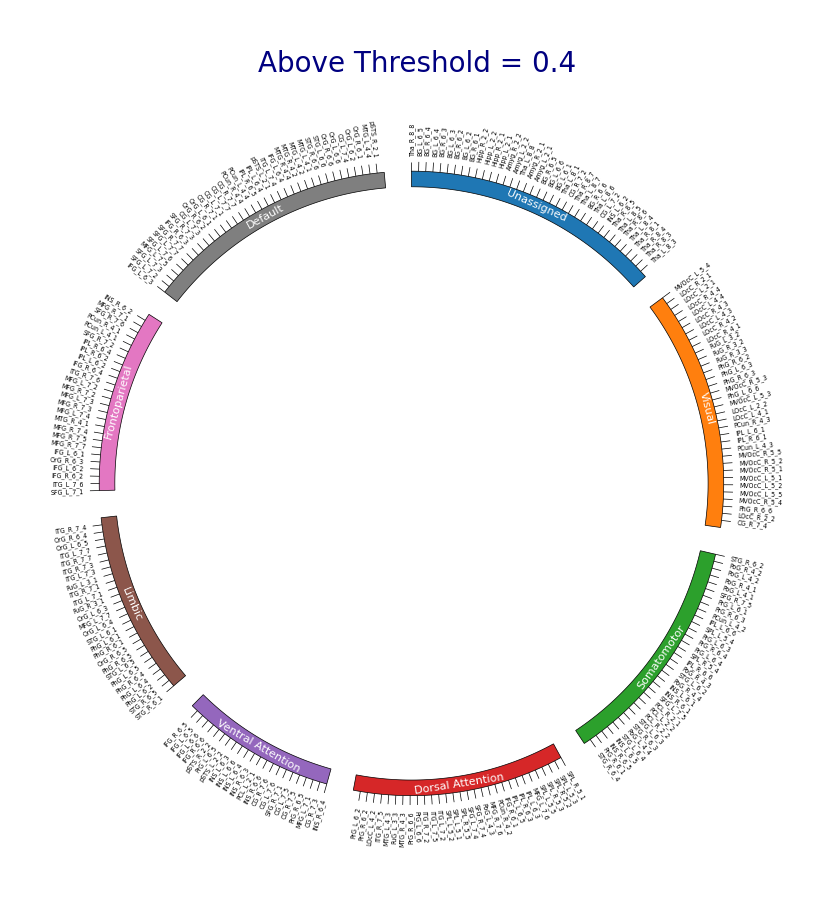

In [48]:
sectors = dict(counts)
print(sectors)

# Using a visually distinct color palette that's colorblind-friendly
name2color = dict(zip(counts.index, sns.color_palette('tab10', len(counts))))

# Create the Circos plot with slightly more space between sectors for clarity
circos = Circos(sectors, space=5)

for sector in circos.sectors:
    track = sector.add_track((95, 100))
    track.axis(fc=name2color[sector.name])

    pos_list = list(range(0, int(track.size)))
    labels = networks.get(sector.name, [])  # Assuming networks is a dictionary

    # Adjust text size and color for better readability
    track.text(sector.name, color="white", size=8, ha='center', va='center')

    # Adjust xticks for better readability
    track.xticks(
        pos_list,
        labels,
        outer=True,
        tick_length=3,
        label_size=4.5,
        label_margin=2,
        label_orientation="vertical"
    )

# Add links/edges between sectors
for edge in edges:
    circos.link_line(edge[0], edge[1])

# # Generating the plot figure with an adjusted size for better readability
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
# circos.plot(ax=ax)
fig = circos.plotfig()

# Enhancing the title with a more descriptive text and adjusting its position
fig.suptitle(f'Above Threshold = {threshold}', fontsize=20, color='navy', va='bottom')

# Saving the figure with a higher resolution
fig.savefig('/Users/jpillai/Documents/test_got.png', dpi=300)  # Adjust the path


In [ ]:
""" OLD CODE USING HOLOVIEWS INTERACTIVE CHORD FUNCTIONS"""
# # Create the DataFrame for the chord diagram (contains all regions and their connections)
# # connections_df = pd.DataFrame({
# #     'source': [edge[0][0] for edge in edges_weights_with_networks],
# #     'target': [edge[0][1] for edge in edges_weights_with_networks],
# #     'value': [edge[1] for edge in edges_weights_with_networks]
# # })

# connections_df_networks = pd.DataFrame({
#     'source': [edge[0] for edge in edges_weights_with_networks.keys()],
#     'target': [edge[1] for edge in edges_weights_with_networks.keys()],
#     'value': list(edges_weights_with_networks.values())
# })

# connections_df = pd.DataFrame({
#     'source': [edge[0] for edge in edges_weights.keys()],
#     'target': [edge[1] for edge in edges_weights.keys()],
#     'value': list(edges_weights.values())
# })

# # If the value is not 0, set it to 1
# connections_df['value'] = connections_df['value'].map(lambda x: 1 if x != 0 else 0)


# # If the value is not 0, set it to 1
# connections_df_networks['value'] = connections_df_networks['value'].map(lambda x: 1 if x != 0 else 0)

# nodes_df = pd.DataFrame(Yeo_7networks_names.items(), columns=['group', 'name'])
# nodes = hv.Dataset(nodes_df, 'index')

# #if the source and target are the same, drop the row
# connections_df = connections_df[connections_df['source'] != connections_df['target']]

# connections_df['value'].unique()